# General setup

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
import xlrd
import os
import matplotlib.colors as colors
import seaborn as sns
import scipy
from sklearn.metrics import mean_squared_error
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as FA
import mpl_toolkits.axisartist.grid_finder as GF

In [12]:
pmip_v4='PMIP4'
pmip_v3='PMIP3'
pmip={}
pmip['PMIP4']=['AWI-CM-1-1-LR',
               'CESM2',
               'EC-EARTH-3-3',
               'FGOALS-f3-L',
               'FGOALS-g3',
               'GISS-E2-1-G',
               'HadGEM3-GC31',
               'IPSL-CM6A-LR',
               'MIROC-ES2L',
               'MPI-ESM1-2-LR',
               'MRI-ESM2-0',
               'NESM3',
               'NorESM1-F',
               'NorESM2',
               'UofT-CCSM-4']
pmip['PMIP3']=['BCC-CSM1-1',
               'CCSM4',
               'CNRM-CM5',
               'CSIRO-Mk3L-1-2',
               'CSIRO-Mk3-6-0',
               'EC-EARTH-2-2',
               'FGOALS-g2',
               'FGOALS-s2',
               'GISS-E2-R',
               'HadGEM2-CC',
               'HadGEM2-ES',
               'IPSL-CM5A-LR',
               'KCM1-2-2',
               'MIROC-ESM',
               'MPI-ESM-P',
               'MRI-CGCM3']

In [3]:
#No change needs here

'''Define calculating functions'''

#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "../DATA" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "../DATA/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "../DATA/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='../DATA/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames

#This function will identify models in the ensemble
def identify_ensemble_members(variable_name,experiment_name):
    datadir="../DATA/%s" %(experiment_name)
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

#This function will list excat model name
def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    
#This function will find an regird avaiable models, calculate changes, and return model data and model names
def ensemble_diffence(pmip_v):
    dataset={}
    model=[]
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_2x2= xr.Dataset({'lat': (['lat'], np.arange(-89,90,2)),
                         'lon': (['lon'], np.arange(-179, 180, 2))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_2x2,'bilinear', reuse_weights=True,periodic=True) 
                diff_2x2=this_regridder(diff)
                model.append(gcm)
                diff_r=np.zeros((90,180))
                for r in range(90):
                    for c in range(180):
                        diff_r[r][c]=diff_2x2[r][c-90]
                dataset[gcm]=diff_r
    fm='TD_dataset/%s_modellist.csv' %pmip_v
    mm=pd.DataFrame(model)
    mm.to_csv(fm)
    return dataset,model

def ensemble_diffence1(pmip_v):
    dataset={}
    model=[]
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_2x2= xr.Dataset({'lat': (['lat'], np.linspace(-90,89,180)),
                         'lon': (['lon'], np.linspace(-180,179,360))})
    
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_2x2,'bilinear', reuse_weights=True,periodic=True) 
                diff_2x2=this_regridder(diff)
                model.append(gcm)
                diff_r=np.zeros((180,360))
                for r in range(180):
                    for c in range(360):
                        diff_r[r][c]=diff_2x2[r][c-180]
                dataset[gcm]=diff_r
    fm='TD_dataset/mat_%s_modellist.csv' %pmip_v
    mm=pd.DataFrame(model)
    mm.to_csv(fm)
    return dataset,model



# Generate csv data files

In [4]:
'''define csv data files'''
#map data file
def recons_var_dataset(v):
    recons_file='mh_recons/%s_delta_06ka_ALL_grid_2x2.nc' %v
    var1='%s_anm_mean' %v
    var2='%s_se_mean' %v
    recons_data=Dataset(recons_file)
    recons_var=recons_data[var1][:]
    recons_err=recons_data[var2][:]    
    xnan1=np.ma.filled(recons_var, np.nan)
    xnan2=np.ma.filled(recons_err, np.nan)
    po={}
    po['lat']=[]
    po['lon']=[]
    po['ref']=[]
    po['err']=[]
    for row in range(90):
        for col in range(180):          
            val_var=str(xnan1[row][col])
            val_err=str(xnan2[row][col])
            if val_var != 'nan':
                val=float(val_var)
                err=float(val_err)
                po['ref'].append(val)
                po['err'].append(err)
                po['lat'].append(row)
                po['lon'].append(col)
    f1='TD_dataset/%s_recons_points.csv'%v
    r1=pd.DataFrame(po)
    r1.to_csv(f1)

#pmip
def model_var_dataset(dataset,model,p,v):
    recons_file='mh_recons/%s_delta_06ka_ALL_grid_2x2.nc' %v
    var1='%s_anm_mean' %v
    recons_data=Dataset(recons_file)
    recons_var=recons_data[var1][:]
    data={}
    for m in model:
        re=[]
        dd=dataset[m]      
        xxx=ma.array(dd,mask=recons_var.mask)
        xnan=np.ma.filled(xxx, np.nan)        
        for row in range(90):
            for col in range(180):
                val=str(xnan[row][col])
                if val != 'nan':
                    val1=float(val)
                    re.append(val1)                  
        data[m]=re
    ddd=pd.DataFrame(data)
    f='TD_dataset/%s_%s_points.csv' %(v,p)
    ddd.to_csv(f)
    return data

In [5]:
# mat data file

def model_var_dataset1(dataset,model,p):
    recons_file='mh_recons/anom6k_annual.nc'
    var1='mat'
    recons_data=Dataset(recons_file)
    recons_var=recons_data[var1][:]
    rr=ma.masked_invalid(recons_var)
    data={}
    for m in model:
        re=[]
        dd=dataset[m]      
        xxx=ma.array(dd,mask=rr.mask)
        xnan=np.ma.filled(xxx, np.nan)        
        for row in range(180):
            for col in range(360):
                val=str(xnan[row][col])
                if val != 'nan':
                    val1=float(val)
                    re.append(val1)                  
        data[m]=re
    ddd=pd.DataFrame(data)
    f='TD_dataset/mat_%s_points.csv' %(p)
    ddd.to_csv(f)
    return data

def model_var_dataset_po1(dataset,model,p):
    recons_file='mh_recons/anom6k_annual.nc'
    var1='mat'
    recons_data=Dataset(recons_file)
    recons_var=recons_data[var1][:]
    rr=ma.masked_invalid(recons_var)
    data={}
    for m in model:
        re=[]
        dd=dataset[m]      
        xxx=ma.array(dd,mask=rr.mask)
        xnan=np.ma.filled(xxx, np.nan)        
        for row in range(180):
            for col in range(360):
                val=str(xnan[row][col])
                if val != 'nan':
                    val1=float(val)
                    r=row-90
                    c=col-180
                    re.append([r,c,val1])                  
        data[m]=re
    ddd=pd.DataFrame(data)
    f='TD_dataset/mat_%s_points_position.csv' %(p)
    ddd.to_csv(f)
    return data

## create files

In [6]:
'''create mat csv files'''
experiment_name='midHolocene'
variable_name='tas_spatialmean_ann'
ensemble_diff_v4,model_diff_v4=ensemble_diffence1(pmip_v4)
ensemble_diff_v3,model_diff_v3=ensemble_diffence1(pmip_v3)
model_var_dataset1(ensemble_diff_v4,model_diff_v4,pmip_v4)
model_var_dataset1(ensemble_diff_v3,model_diff_v3,pmip_v3)

/Users/annie/anaconda3/envs/an/lib/python3.7/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'nino34_autocorrelation' has multiple fill values {-1073741800.0, 1e+30}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_80x180_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_96x144_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_1

{'BCC-CSM1-1': [-0.012239735835679295,
  0.1105260458047542,
  0.1670274997383574,
  0.05542234091643153,
  0.2224277171267758,
  0.14399410061785933,
  0.169203430830038,
  -0.08380291961600489,
  -0.26774172986054934,
  -0.2038478414143386,
  -0.07923109315707673,
  -0.24171926618667505,
  -0.04075040197676506,
  -0.054247154631281394,
  -0.05283706034832746,
  -0.044955892699356584,
  -0.056059096907103326,
  -0.21378822935941233,
  -0.06736551484980632,
  -0.10073840518767964,
  -0.1164384156778252,
  -0.11717578299289173,
  -0.24919884889294747,
  -0.20554389013546553,
  -0.4132583895734867,
  -0.4542026439161532,
  -0.5045982282446256,
  -0.11554794342626762,
  -0.4069543521847642,
  -0.22476254276842564,
  -0.4450442258683396,
  -0.4493029435503504,
  -0.2600671473745804,
  -0.3227610938219946,
  -0.34618092567003755,
  -0.41822854869944914,
  -0.23510748065730233,
  -0.21448777795075047,
  -0.3867123012843847,
  -0.41011390328980046,
  -0.17939784387818317,
  -0.253771307792776

In [7]:
'''create map csv files'''
v='map'
experiment_name='midHolocene'
variable_name='pr_spatialmean_ann'
ensemble_diff_v4,model_diff_v4=ensemble_diffence(pmip_v4)
ensemble_diff_v3,model_diff_v3=ensemble_diffence(pmip_v3)
model_var_dataset(ensemble_diff_v4,model_diff_v4,pmip_v4,v)
model_var_dataset(ensemble_diff_v3,model_diff_v3,pmip_v3,v)

Reuse existing file: bilinear_96x192_90x180_peri.nc
Reuse existing file: bilinear_192x288_90x180_peri.nc
Reuse existing file: bilinear_180x288_90x180_peri.nc
Reuse existing file: bilinear_80x180_90x180_peri.nc
Reuse existing file: bilinear_90x144_90x180_peri.nc
Reuse existing file: bilinear_144x192_90x180_peri.nc
Reuse existing file: bilinear_143x144_90x180_peri.nc
Reuse existing file: bilinear_64x128_90x180_peri.nc
Reuse existing file: bilinear_160x320_90x180_peri.nc
Reuse existing file: bilinear_96x192_90x180_peri.nc
Reuse existing file: bilinear_96x144_90x180_peri.nc
Reuse existing file: bilinear_192x288_90x180_peri.nc
Reuse existing file: bilinear_64x128_90x180_peri.nc
Reuse existing file: bilinear_192x288_90x180_peri.nc
Reuse existing file: bilinear_128x256_90x180_peri.nc
Reuse existing file: bilinear_96x192_90x180_peri.nc
Reuse existing file: bilinear_56x64_90x180_peri.nc
Reuse existing file: bilinear_160x320_90x180_peri.nc
Reuse existing file: bilinear_60x128_90x180_peri.nc
Reus

/Users/annie/anaconda3/envs/an/lib/python3.7/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'nino34_autocorrelation' has multiple fill values {-1073741800.0, 1e+30}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


Reuse existing file: bilinear_64x128_90x180_peri.nc
Reuse existing file: bilinear_96x192_90x180_peri.nc
Reuse existing file: bilinear_160x320_90x180_peri.nc


{'BCC-CSM1-1': [0.03720946100724853,
  0.022346114545687003,
  -0.0067153009448325494,
  -0.005833927271647928,
  0.02964417720567866,
  0.008897153615485825,
  0.0029152449638356216,
  0.019906129396595,
  0.02794387796641708,
  -0.02168870623969107,
  -0.0680142819211167,
  -0.38580641530929183,
  -0.3996553509372187,
  -0.11946981449279782,
  -0.12365343531169677,
  -0.12247241769507665,
  -0.18347914519635897,
  -0.1640111007997387,
  0.03151556437333066,
  0.06064580595045377,
  0.07300833685671274,
  -0.20264641134117473,
  -0.10328826306060362,
  -0.09149557398347694,
  -0.2633866860543005,
  0.04104920431380254,
  0.06022334882002291,
  -0.3284335794522869,
  0.012838240154557343,
  -0.05989642676327383,
  -0.03636462802653678,
  0.06652353689348764,
  0.12937267260403443,
  -0.758711978568428,
  -0.2861384322918442,
  -0.8236402937766313,
  -0.29060762125183515,
  0.25381363867213247,
  0.542251929899092,
  0.4975899821609613,
  0.49257431308167676,
  -0.010596977737831482,
  

# Generate TD dataset

In [8]:
def data_frame_mat(pmip_v):
    v='mat'
    modellist_filename='TD_dataset/%s_modellist.csv' %pmip_v
    recons_filename='mh_recons/anom6k_annual.csv'
    model_filename='TD_dataset/%s_%s_points.csv' %(v,pmip_v)
    modellist= pd.read_csv(modellist_filename,skipinitialspace=True,header=0,usecols=['0']) 
    recons=pd.read_csv(recons_filename,skipinitialspace=True,header=0,usecols=['anom']) 
    model=pd.read_csv(model_filename,skipinitialspace=True,header=0,usecols=modellist['0'])
    recons_var=recons['anom']
    err=0.837108392
    trusd=math.sqrt(np.mean(np.square(recons_var-np.mean(recons_var))-err))
    DATA={}
    DATA['model_name']=[]
    DATA['rmsd']=[]
    DATA['ssdd']=[]
    DATA['corr']=[] 
    DATA['i']=[]
    for i,m in enumerate(modellist['0']):
        DATA['i'].append(i)
        model_var=np.array(model[m])
        rmsd=math.sqrt(np.mean(np.square(recons_var-np.mean(recons_var)-model_var+np.mean(model_var)))-err)/trusd
        ssdd=math.sqrt(np.mean(np.square(model_var-np.mean(model_var))))/trusd
        corr=(ssdd**2+1-rmsd**2)/(2*ssdd)
        DATA['model_name'].append(m)
        DATA['rmsd'].append(rmsd)
        DATA['ssdd'].append(ssdd)
        DATA['corr'].append(corr)
    data=pd.DataFrame(DATA)
    return data


def data_frame_map(pmip_v):
    v='map'
    modellist_filename='TD_dataset/%s_modellist.csv' %pmip_v
    recons_filename='TD_dataset/%s_recons_points.csv'%v
    model_filename='TD_dataset/%s_%s_points.csv' %(v,pmip_v)
    modellist= pd.read_csv(modellist_filename,skipinitialspace=True,header=0,usecols=['0']) 
    recons=pd.read_csv(recons_filename,skipinitialspace=True,header=0,usecols=['ref','err']) 
    model=pd.read_csv(model_filename,skipinitialspace=True,header=0,usecols=modellist['0'])
    recons_var=recons['ref']/365
    recons_err=recons['err']/365
    trusd=math.sqrt(np.mean(np.square(recons_var-np.mean(recons_var))-np.mean(np.square(recons_err))))
    DATA={}
    DATA['model_name']=[]
    DATA['rmsd']=[]
    DATA['ssdd']=[]
    DATA['corr']=[] 
    DATA['i']=[]
    for i,m in enumerate(modellist['0']):
        DATA['i'].append(i)
        model_var=np.array(model[m])
        rmsd=math.sqrt(np.mean(np.square(recons_var-np.mean(recons_var)-model_var+np.mean(model_var)))-np.mean(np.square(recons_err)))/trusd
        ssdd=math.sqrt(np.mean(np.square(model_var-np.mean(model_var))))/trusd
        corr=(ssdd**2+1-rmsd**2)/(2*ssdd)
        DATA['model_name'].append(m)
        DATA['rmsd'].append(rmsd)
        DATA['ssdd'].append(ssdd)
        DATA['corr'].append(corr)
    data=pd.DataFrame(DATA)
    return data

#This function will collect varibales and bulid data frame plotted in TD
def data_TD(DATA):
    data=[]
    for i in range(len(DATA['model_name'])):
        model=DATA['model_name'][i]
        std=DATA['ssdd'][i]
        rho=DATA['corr'][i]
        data.append([std,rho,model])
    return data




In [14]:
data4_mat=data_frame_mat('PMIP4')
data3_mat=data_frame_mat('PMIP3')

In [15]:
data4_map=data_frame_map('PMIP4')
data3_map=data_frame_map('PMIP3')

In [16]:
map3=data_TD(data3_map)
map4=data_TD(data4_map)
mat3=data_TD(data3_mat)
mat4=data_TD(data4_mat)

# Make TD plot

In [17]:
# copied from https://gist.github.com/ycopin/3342888
#A few changes have been made
class TaylorDiagram(object):
    """
    Taylor diagram.

    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.

        Parameters:

        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = np.array([0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = np.pi
            rlocs = np.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = np.pi/2
        tlocs = np.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = plt.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        #ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, color='g',marker='s',mec='k',mew=2,
                          ls='', ms=10, label=label)
        t = np.linspace(0, self.tmax)
        r = np.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'g',lw=2, label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(np.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax),
                             np.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = np.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*np.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours




In [18]:
def TD_plot(data1,data2,data3,data4):
    """
    Climatology-oriented example (after iteration w/ Michael A. Rawlins).
    """

    # Reference std
    stdref = 1

    # Samples std,rho,name
    samples1 = data1
    samples2 = data2
    samples3 = data3
    samples4 = data4
    

    fig = plt.figure(figsize=(20,14))

    dia = TaylorDiagram(stdref, fig=fig, extend=True)
    #dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name) in enumerate(samples1):
        dia.add_sample(stddev, corrcoef,
                       marker='o', mec='darkred',fillstyle='none',mew=1.5, ms=10)

    for i, (stddev, corrcoef, name) in enumerate(samples2):
        dia.add_sample(stddev, corrcoef,
                       marker='o',mec='salmon', fillstyle='none',mew=1.5, ms=10)
    
    for i, (stddev, corrcoef, name) in enumerate(samples3):
        dia.add_sample(stddev, corrcoef,
                       marker='P', mec='darkblue',fillstyle='none',mew=1.5, ms=10)

    for i, (stddev, corrcoef, name) in enumerate(samples4):
        dia.add_sample(stddev, corrcoef,
                       marker='P',mec='lightblue', fillstyle='none',mew=1.5, ms=10)
    
    





    # Add RMS contours, and label them
    contours = dia.add_contours(levels=15, colors='g',linewidths=0.5,linestyles='dashdot')  # 5 levels in grey
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.1f')

    dia.add_grid(ls=(0, (1, 10)),color='b',lw=0.5,label='Standard Deviation')                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward
    plt.axvline(x=0,color='k',lw=1.5)
   
    # Add a figure legend and title
    #fig.legend(dia.samplePoints,
     #          [ p.get_label() for p in dia.samplePoints ],
     #          numpoints=1, prop=dict(size='small'), loc='upper right')
    #fig.suptitle("Taylor diagram", size='x-large')  # Figure title
    plt.xlabel('Standard Deviation')
    plt.savefig('figs/TD_mat_map1.png')

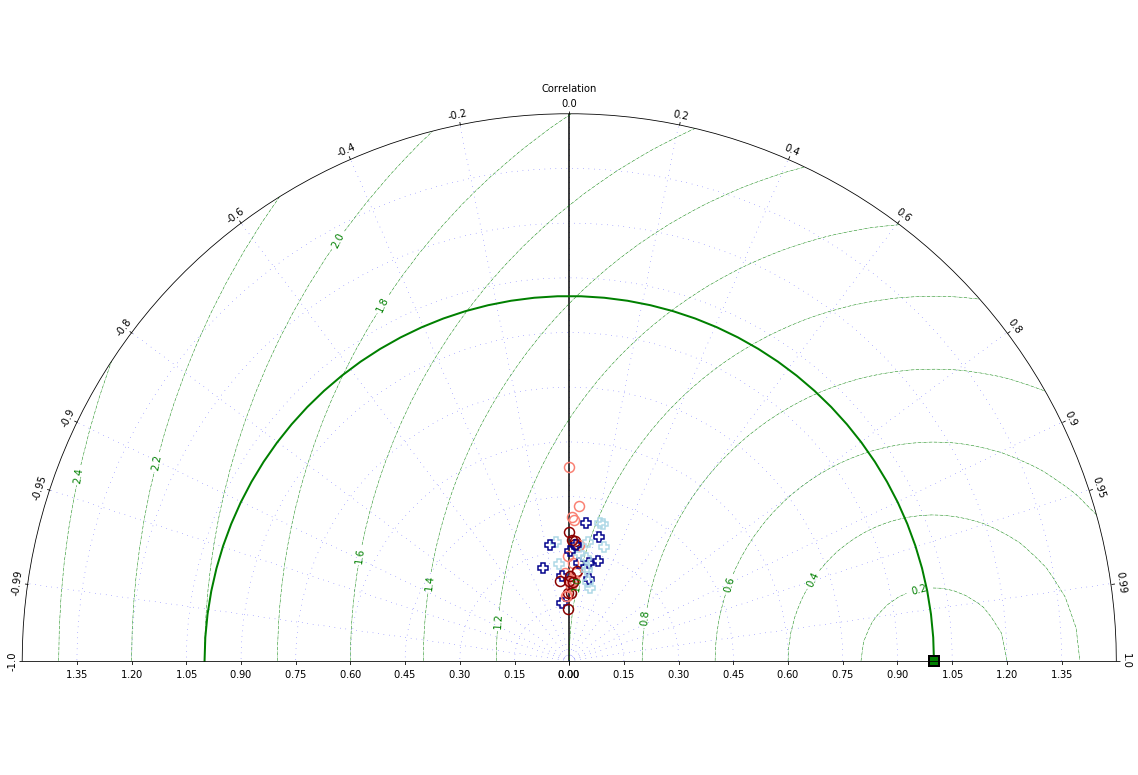

In [19]:
#MH ALL
TD_plot(mat4,mat3,map4,map3)